# Periodic Bspline

### Pacchetti

In [1]:
import pyBspline as Bs
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
#import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import scipy
from scipy.misc import derivative
from scipy.optimize import curve_fit
import pandas as pd
#from ipywidgets import interactive
#import ipywidgets as widgets
#from ipywidgets import AppLayout, FloatSlider
#from mpl_toolkits.mplot3d import Axes3D
import copy
import pandas as pd
#from scipy import integrate
#import itertools 
#import time
import os
import scipy.special
import re

[NbConvertApp] Converting notebook pyBspline.ipynb to script
[NbConvertApp] Writing 79136 bytes to pyBspline.py


## Triangle $k=20,P=1,N=100$

### Definition

In [2]:
k_in = 20*np.asarray([0.5,np.sqrt(3)/2])
wavevector = np.sqrt(np.sum(np.power(k_in,2.0)))
I = np.complex(0,1)

xmin = -1.5
xmax = 1.5
ymin = -1.5
ymax = 1.5

In [3]:
#definisco la dimensionaità:
sh = Bs.shape(1,2)
#sh.show()

#defiisco i knot vector
P=1 #polinomial degree
N=20 #base caridnality
xminBs = 0.0
xmaxBs = 1.0


#
#kv = Bs.uniform_open_kv(xmin,xmax,p=P,n=N)#Bs.knot_vector(P,N,v)
#kv = periodic_kv(xmin,xmax,p=P,n=N)
kv = Bs.periodic_kv(xminBs,xmaxBs,p=P,n=N)
kv.show()

#alloco la Bspline
bs = Bs.Bspline(sh,[kv],properties={"periodic":[True]})

polinomial degree :  1
base caridnality  :  22
knots             :  [-0.05  0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5
  0.55  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1 ]


In [4]:
file_dir = "files/BEM/triangle-periodic/"
suffix = "P="+str(P)+"-N="+str(N)+"-k="+str(wavevector)+".csv"

In [5]:
x0 = -0.5
y0 =  -0.5

a = 1.0 / (2+np.sqrt(2))
b = (1.0+np.sqrt(2)) / (2+np.sqrt(2))
delta = b-a

sx = 1.0
sy = 1.0

def triangle_x(i):
    if i <= a :
        return i
    elif i > a and i <= b :
        j = i-a
        return a - j*a/(delta)
    else :
        return 0
    
def triangle_y(i):
    if i <= a :
        return 0
    elif i > a and i <= b :
        j = i-a
        return j*a/(delta)
    else :
        j = i-b
        return a-j
    
def func(t):
    out = np.zeros((len(t),2))
    out[:,0] = [triangle_x(i) for i in t]
    out[:,1] = [triangle_y(i) for i in t]
            
    out[:,0] = sx*out[:,0]/a+x0
    out[:,1] = sy*out[:,1]/a+y0
    return out

In [6]:
#ATTENZIONE: mi servono dei punti distribuiti in modo uniforme
# per come ho costruito func so che
# func(0.) = func(1.)
# quindi genero un punto in più
t = np.linspace(0,1,N+1,endpoint=True)#[0:-2]
cp = func(t)
for i in range(len(t)):
    #bs._cp[i] = cp[i]
    bs.set_cp(i,cp[i])
cpx = cp[:,0]
cpy = cp[:,1]

In [7]:
#bs.control_points()

### Geometry

In [8]:
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
Txy = func(T)
df = pd.DataFrame(xy)
df = df.rename(columns={0:"x",1:"y"})

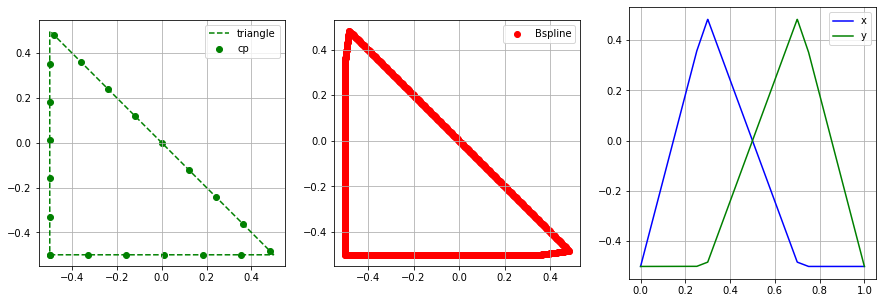

In [9]:
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#converto in dataframe    
ax = fig.add_subplot(131)
plt.plot(Txy[:,0],Txy[:,1],color="green",label="triangle",linestyle="--")
plt.scatter(cpx,cpy,color="green",label="cp")
#plt.scatter(df["x"], df["y"], color= "red",label="Bspline")
plt.grid()
plt.legend()
ax.set_aspect('equal')

ax = fig.add_subplot(132)
#plt.plot(cpx,cpy,color="green",label="cp",linestyle="--")
#plt.scatter(cpx,cpy,color="green",label="cp")
plt.scatter(df["x"], df["y"], color= "red",label="Bspline")
plt.grid()
plt.legend()
ax.set_aspect('equal')

#real
ax = fig.add_subplot(133)#, projection='3d')
ax.plot(T,df["x"],color="blue",label="x")
ax.plot(T,df["y"],color="green",label="y")
#ax.plot(df["t"],np.real(df["trace"]),color="red",label="trace")
#plt.title("real")
plt.grid(True)
plt.legend()
plt.show()

### Stiffness Matrix

In [10]:
file = file_dir+"stiffness_matrix-"+suffix
file

'files/BEM/triangle-periodic/stiffness_matrix-P=1-N=20-k=20.0.csv'

In [11]:
READ = False
SAVE = True
if os.path.exists(file) and READ == True :
    sm = bs.load("sm-BEM",file)
else :
    sm,out = bs.stiffness_matrix_BEM(k=wavevector,opts={"print":True,"return_both":True,"ready_sm_BEM":False})
    if SAVE == True :
        bs.save("sm-BEM",file)
#sm

stiffness_matrix_BEM
Finished3 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253 / 253


In [12]:
#
def plot_matrix(sm):
    #
    sm2 = sm.copy()
    sm2["index"] = sm2.index
    #
    new = sm2.melt(id_vars=['index'])# = sm.index
    #
    new2 = new.copy()
    new2["index"] = [ i[0] for i in new2["index"]]
    new2["variable"] = [ i[0] for i in new2["variable"]]
    #new2["value"] = [np.complex(i) for i in new2["value"] ]
    new2["real"] = np.real(new2["value"])
    new2["imag"] = np.imag(new2["value"])
    new2["abs"] = np.absolute(new2["value"])
    new2["phase"] = np.angle(new2["value"])/np.pi
    df = new2
    
    #
    fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

    cmap = 'RdYlBu'

    #
    ax = fig.add_subplot(221)
    sc = ax.scatter(df["index"],df["variable"],c=df["real"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : real")

    #
    ax = fig.add_subplot(222)
    sc = ax.scatter(df["index"],df["variable"],c=df["imag"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : imag")

    #
    ax = fig.add_subplot(223)
    sc = ax.scatter(df["index"],df["variable"],c=df["abs"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : abs")

    #
    ax = fig.add_subplot(224)
    sc = ax.scatter(df["index"],df["variable"],c=df["phase"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : $\\theta / \pi$")

    plt.tight_layout()
    plt.savefig("non-per.png")
    plt.show()
    

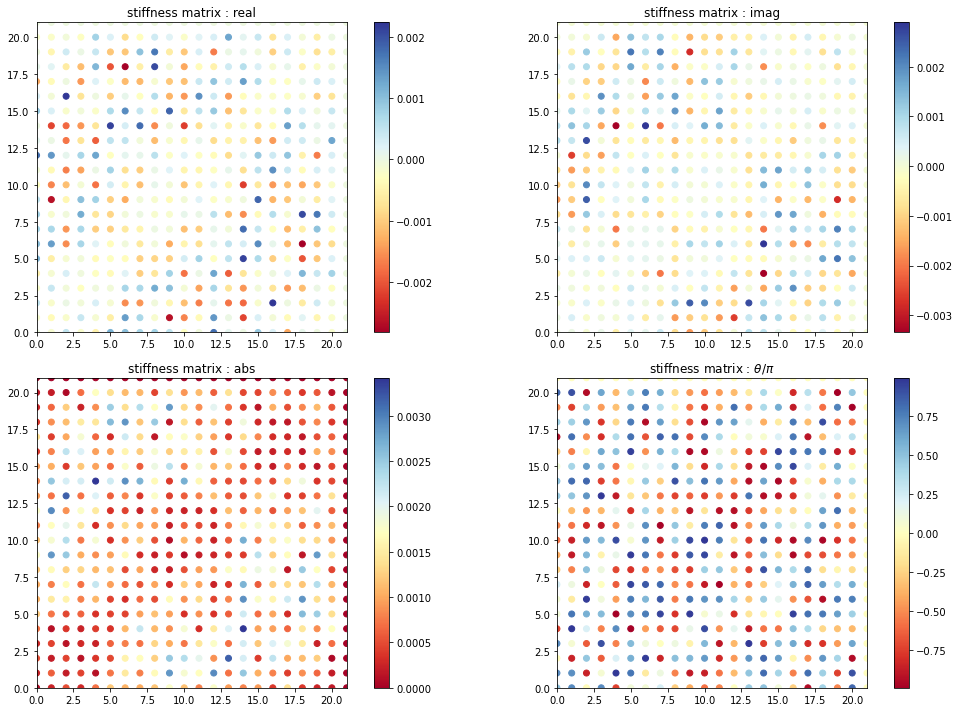

In [13]:
plot_matrix(out)

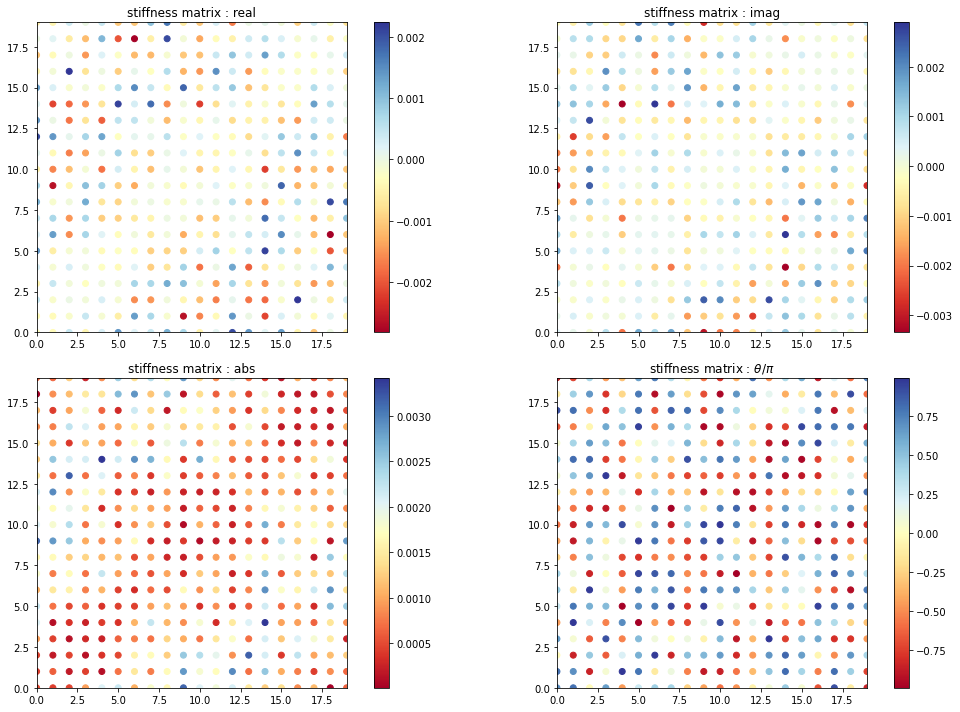

In [14]:
plot_matrix(sm)

In [130]:
#bs.periodicity()
# 0 -> 20
# 1 -> 21

In [133]:
print(persm.shape)
print(out.shape)

persmnp = np.asarray(persm)
outnp = np.asarray(out)

(20, 20)
(22, 22)


In [134]:
# copio la colonna 20 nella colonna 0
n = outnp.shape[0]
for i in range(n):
    outnp[i,0] += outnp[i,20]

    # copio la colonna 21 nella colonna 1
    outnp[i,1] += outnp[i,21]

    # copio la riga 20 nella riga 0
    outnp[0,i] += outnp[20,i]

    # copio la riga 21 nella riga 1
    outnp[1,i] += outnp[21,i]

In [135]:
outnp = np.delete(outnp,21,axis=0)
outnp = np.delete(outnp,21,axis=1)

outnp = np.delete(outnp,20,axis=0)
outnp = np.delete(outnp,20,axis=1)

In [136]:
np.any(outnp == persmnp)

True

In [137]:
prova = pd.DataFrame(data=outnp,index=persm.index,columns=persm.columns)

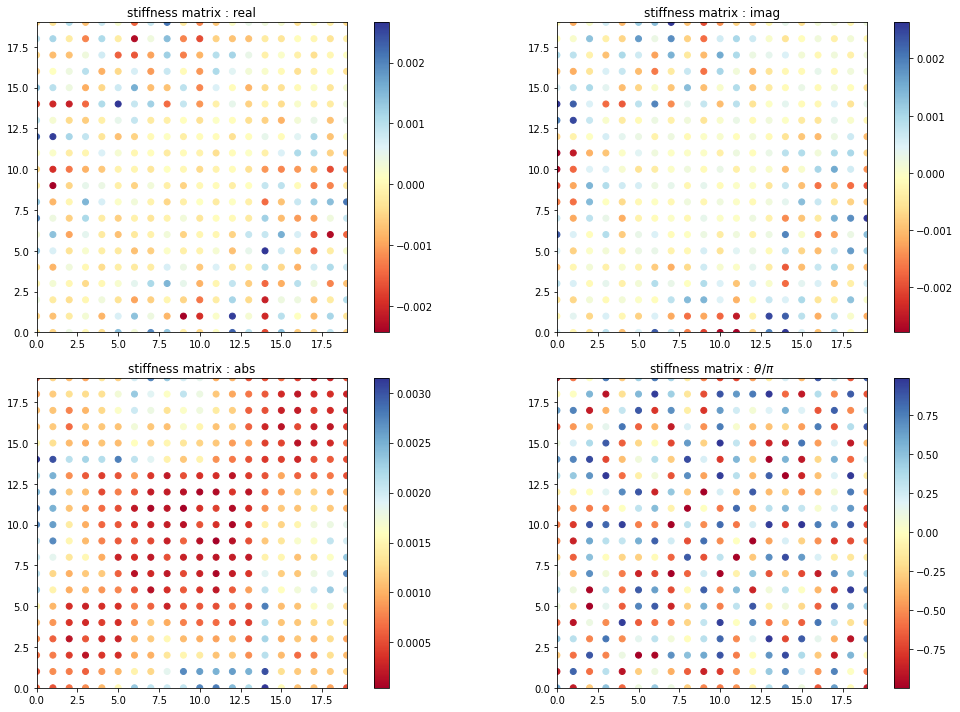

In [138]:
plot_matrix(prova)

### Plane wave

In [15]:
def plot(fig,n,xB,yB,x,y,c,title,cmap):
    
    ax = fig.add_subplot(n)
    ax.plot(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    ax.set_aspect('equal')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(title)
    
    return

In [16]:
Nx= int(xmax-xmin)*20
Ny = int(ymax-ymin)*20
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY = np.zeros((Nx*Ny,2))
XY[:,0] = X.reshape((Nx*Ny,))
XY[:,1] = Y.reshape((Nx*Ny,))

#tolgo elementi interni
#radius = np.asarray([np.sqrt(np.sum(np.power(i,2.0))) for i in XY])
internal = bs.internal_points(XY=XY,NN=1000,xmin=0.,xmax=1.,opts=None)

In [17]:
XYslp = XY[ np.logical_not(internal) ]
print(len(XYslp)," = ",len(XYslp)/3600,"h")

3392  =  0.9422222222222222 h


In [18]:
def plane_wave(xx): # soluzione
    xx = np.asarray(xx)
    theta = np.dot(xx,k_in)
    return np.exp(I*theta)

In [19]:
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
uinc = plane_wave(xy)

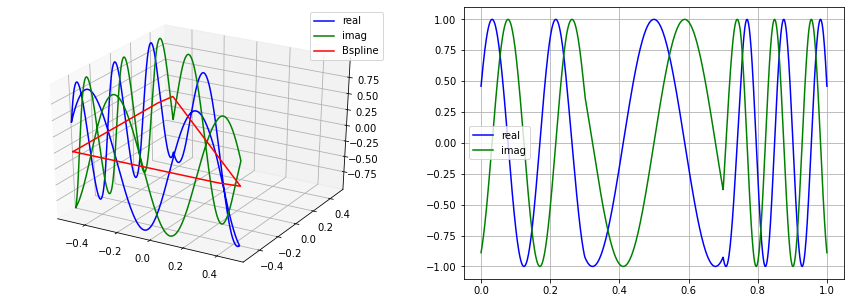

In [20]:
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#
#s = 0.2
ax = fig.add_subplot(121, projection='3d')
ax.plot(xy[:,0], xy[:,1],uinc.real,color="blue",label="real")
ax.plot(xy[:,0], xy[:,1],uinc.imag,color="green",label="imag")
ax.plot(xy[:,0], xy[:,1],0.0,color="red",label="Bspline")
plt.grid(True)
plt.legend()

#
ax = fig.add_subplot(122)#, projection='3d')
ax.plot(T,uinc.real,color="blue",label="real")
ax.plot(T,uinc.imag,color="green",label="imag")
plt.grid(True)
plt.legend()

plt.show()

In [21]:
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
df = pd.DataFrame(xy)
df = df.rename(columns={0:"x",1:"y"})

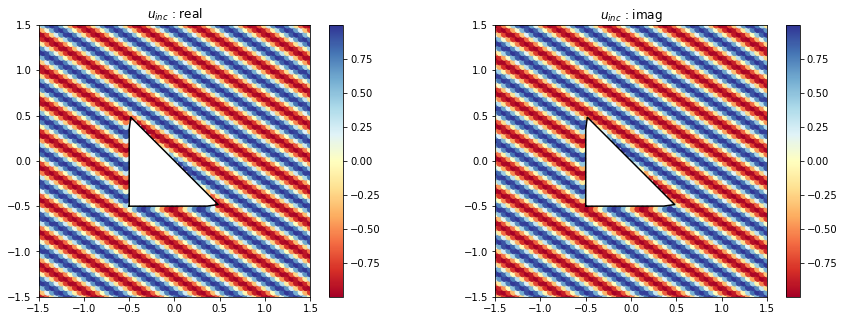

In [22]:
fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )

Uinc = plane_wave(XYslp)

cmap = 'RdYlBu'
    
plot(fig,121,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Uinc.real,"$u_{inc}$ : real",cmap)
plot(fig,122,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Uinc.imag,"$u_{inc}$ : imag",cmap)

plt.show()

### Single Layer Potential basis

In [23]:
file = file_dir+"single_layer_potential-"+suffix
file

'files/BEM/triangle-periodic/single_layer_potential-P=1-N=20-k=20.0.csv'

In [ ]:
READ = False
SAVE = True
if os.path.exists(file) and READ == True :
    slp = bs.load("slp-BEM",file)
else :
    slp = bs.single_layer_potential_basis_BEM(XY=XYslp,k=wavevector,opts={"print":True})
    if SAVE == True :
        bs.save("slp-BEM",file)
#slp

### Solution

In [ ]:
#
file_sol = file_dir+"solution-plane_wave-"+suffix
file_lv  = file_dir+"load_vector-plane_wave-"+suffix
file_ind = file_dir+"indirect_solution-plane_wave-"+suffix
print(file_sol)
print(file_lv)
print(file_ind)

In [ ]:
#
READ = False
SAVE = True
if os.path.exists(file_sol) and READ == True :
    sol,Xnp,Valnp = bs.load("sol-BEM",file_sol)
    
if os.path.exists(file_lv) and READ == True :
    sol = bs.load("lv-BEM",file_lv)
    
if os.path.exists(file_ind) and READ == True :
    sol = bs.load("ind_sol-BEM",file_ind)
    
else :
    sol,Xnp,Valnp = bs.BEM(uinc=plane_wave,k=wavevector,XY=XYslp,opts=None)
    if SAVE == True :
        bs.save("sol-BEM",file_sol)
        bs.save("lv-BEM",file_lv)
        bs.save("ind_sol-BEM",file_ind)
#sol

In [ ]:
#
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
df = pd.DataFrame(xy)
df = df.rename(columns={0:"x",1:"y"})

Uinc = plane_wave(XYslp)#.reshape(Nx,Ny).transpose()
total = Uinc + Valnp

In [ ]:
#grafico
fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

cmap = 'RdYlBu'

def plot(fig,n,xB,yB,x,y,c,title):
    
    ax = fig.add_subplot(n)
    ax.plot(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    ax.set_aspect('equal')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(title)
    
    return
    
plot(fig,331,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Uinc.real,"$u_{inc}$ : real")
plot(fig,334,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Uinc.imag,"$u_{inc}$ : imag")
plot(fig,337,df["x"], df["y"],XYslp[:,0],XYslp[:,1],np.absolute(Uinc),"$u_{inc}$ : abs")

plot(fig,332,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Valnp.real,"$u_{scat}$ : real")
plot(fig,335,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Valnp.imag,"$u_{scat}$ : imag")
plot(fig,338,df["x"], df["y"],XYslp[:,0],XYslp[:,1],np.absolute(Valnp),"$u_{scat}$ : abs")

plot(fig,333,df["x"], df["y"],XYslp[:,0],XYslp[:,1],total.real,"$u_{tot}$ : real")
plot(fig,336,df["x"], df["y"],XYslp[:,0],XYslp[:,1],total.real,"$u_{tot}$ : imag")
plot(fig,339,df["x"], df["y"],XYslp[:,0],XYslp[:,1],np.absolute(total),"$u_{tot}$ : abs")

plt.show()

### Test

In [ ]:
test = bs.copy()

In [ ]:
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=False)
xy   = bs.evaluate(T)
uinc = plane_wave(xy)

In [ ]:
READ = True
SAVE = False

file = file_dir+"test-slp-basis-plane_wave-"+suffix
print(file)


if os.path.exists(file) and READ == True :
    slpB = test.load("slp-BEM",file)
    
else :    
    opts = opts={"ready_slp_BEM":False,"copy_slp_BEM":False,"print":True}
    slpB = test.single_layer_potential_basis_BEM(XY=xy,k=wavevector,opts=opts)
    if SAVE == True :
        test.save("slp-BEM",file)

In [ ]:
opts = opts={"print":True,"ready_sol_BEM":False}
ind_sol = test.indirect_solution_BEM()
sol = test.single_layer_potential_BEM(sol=ind_sol,slpB=slpB,XY=xy,k=wavevector,opts=opts)

In [ ]:
lv = test.load_vector_BEM()

In [ ]:
temp = test._scalar()
temp.properties["dtype"] = np.complex
#temp._cp.astype(np.complex)
temp.clear_cp()
for i in ind_sol.index :
    temp.set_cp(i,lv.at[i,"cp"])

In [ ]:
index = sol.index
columns = ["t","x","y","uinc","lv","trace"]
df = pd.DataFrame(index=index,columns=columns)
df["t"] = T
df["x"] = xy[:,0] 
df["y"] = xy[:,1]
df["uinc"] = uinc
df["lv"] = temp.evaluate(T)
df["trace"] = sol["value"]
df.head()

In [ ]:
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#real
ax = fig.add_subplot(111)#, projection='3d')
ax.plot(df["t"],df["x"],color="blue",label="x")
ax.plot(df["t"],df["y"],color="green",label="y")
#ax.plot(df["t"],np.real(df["trace"]),color="red",label="trace")
#plt.title("real")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
fig = plt.figure ( 0 , figsize = ( 15, 8 ) )

#real
ax = fig.add_subplot(221)#, projection='3d')
ax.plot(df["t"],np.real(df["uinc"]),color="blue",label="$u_{inc}$")
ax.plot(df["t"],np.real(df["lv"]),color="green",label="lv")
#ax.plot(df["t"],np.real(df["trace"]),color="red",label="trace")
plt.title("real")
plt.grid(True)
plt.legend()

#imag
ax = fig.add_subplot(222)#, projection='3d')
ax.plot(df["t"],np.imag(df["uinc"]),color="blue",label="$u_{inc}$")
ax.plot(df["t"],np.imag(df["lv"]),color="green",label="lv")
#ax.plot(df["t"],np.imag(df["trace"]),color="red",label="trace")
plt.title("real")
plt.grid(True)
plt.legend()


#real
ax = fig.add_subplot(223)#, projection='3d')
ax.plot(df["t"],np.absolute(df["uinc"]),color="blue",label="$u_{inc}$")
ax.plot(df["t"],np.absolute(df["lv"]),color="green",label="lv")
#ax.plot(df["t"],np.real(df["trace"]),color="red",label="trace")
plt.title("abs")
plt.grid(True)
plt.legend()

#imag
ax = fig.add_subplot(224)#, projection='3d')
ax.plot(df["t"],np.angle(df["uinc"]),color="blue",label="$u_{inc}$")
ax.plot(df["t"],np.angle(df["lv"]),color="green",label="lv")
#ax.plot(df["t"],np.imag(df["trace"]),color="red",label="trace")
plt.title("phase")
plt.grid(True)
plt.legend()

plt.show()

- devo controllare che il valore della soluzione indiretta (soluzione del problema di Galerkin) sia effettivamente uguale a quello richiesto, cioè sia uguale alla traccia della funzione incidente sul bordo dell'oggetto in esame, cioè $\gamma^+ u_{inc}=g_D$ sul bordo $\Gamma$
- nel nostro caso i valori assunti da $g_D$ sono contenuti nel \textit{load vector}
- farò quindi un grafico della parte reale e immaginaria di $g_D$ e di \textit{sol} in funzione del parametro $t\in\left[0,1\right]$
- dai risultati NON CORRETTI visti sopra mi aspetto una grossa discrepanza tra i due valori, che invece dovrebbero coincidere

- continuo ad avere dei problemi nella matrice di stiffness, è visibile nel grafico, ho dei problemi per i control points di bordo